In [1]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
# DatasetCatalog.remove("coco_train_subset")
# MetadataCatalog.remove("coco_train_subset")
register_coco_instances("coco_train_dog", {}, "../datasets/coco/annotations/dog_instances_train2017.json", "../datasets/coco/train2017_dog")
# DatasetCatalog.remove("coco_val_subset")
# MetadataCatalog.remove("coco_val_subset")
register_coco_instances("coco_val_dog", {}, "../datasets/coco/annotations/dog_instances_val2017.json", "../datasets/coco/val2017_dog")

In [3]:
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("coco_train_dog")
my_dataset_metadata.thing_classes = ["dog"]
dataset_dicts = DatasetCatalog.get("coco_train_dog")

from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
import torch

# load simple ResNet-50 model without FPN
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") #ImageNet pre-trained
cfg.OUTPUT_DIR = "knize/output/dog20241111"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

cfg.DATASETS.TRAIN = ("coco_train_dog",)
cfg.DATASETS.TEST = ("coco_val_dog",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# solver config (guesses)
# 4385 dog images to train on
cfg.SOLVER.IMS_PER_BATCH = 8
# cfg.SOLVER.BASE_LR = 0.00025 # just going to try to use the base lr
cfg.SOLVER.MAX_ITER = 1200 # about 2 epochs
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.SOLVER.STEPS = [] # disable learning decay

# run on GPU
cfg.MODEL.DEVICE = 'cuda'

# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=True)
# trainer.model.to(cfg.MODEL.DEVICE)
# inputs = inputs.to(cfg.MODEL.DEVICE)

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# evaluate performance of trained subset model
cfg.MODEL.WEIGHTS = "./knize/output/dog20241111/model_0000999.pth"

# trainer.model.eval()
trainer = DefaultTrainer(cfg)

# evaluator = COCOEvaluator("coco_val_dog", ("bbox",), False, output_dir="./knize/output/dog_20241111")
# val_loader = build_detection_test_loader(cfg, "coco_val_dog")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))

## I don't know why the score doesn't evaluate correctly when loading the model

[11/12 06:39:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/12 06:39:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./knize/output/dog20241111/model_0000999.pth ...
[11/12 06:39:51 d2.data.datasets.coco]: Loaded 177 images in COCO format from ../datasets/coco/annotations/dog_instances_val2017.json


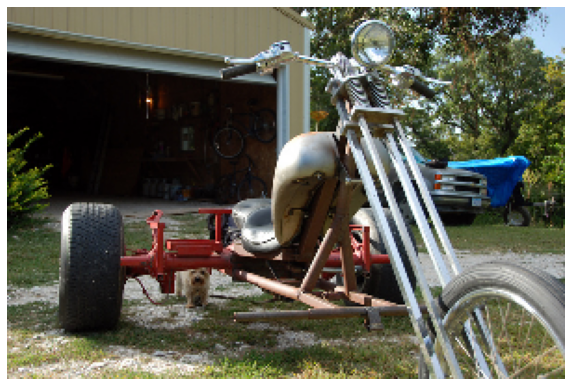

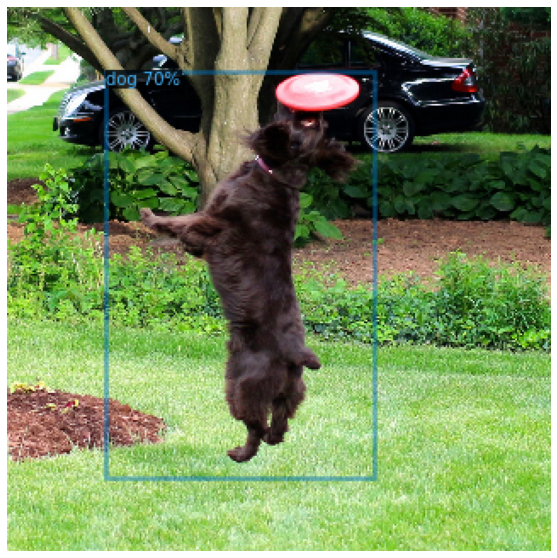

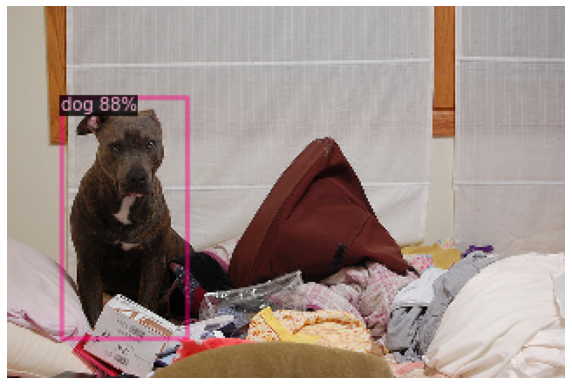

In [13]:
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("coco_val_dog")

for d in dataset_dicts[0:3]:
    img = cv2.imread(d["file_name"])
    
    # Get model predictions
    outputs = predictor(img)
    
    # Visualize the predictions
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("coco_val_dog"), scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()